# 02. Exploratory Analysis - Nubank AI Core Transaction Dataset Interview Project

This is the continuation of the exploratory analysis of the Nubank project dataset. This notebook will continue to look at other features of the dataset, namely the `Amount`, `Trasaction Date` and `Posted Date` columns.

In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

sns.set_theme()
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#8A05BE", "#BA4DE3", "#191919"]) 

In [2]:
df = pd.read_csv('./nubank_checkpoint_01.csv')

In [3]:
df.head()

,Year-Month,Agency Number,Agency Name,Cardholder Last Name,Cardholder First Initial,Amount,Vendor,Transaction Date,Posted Date,Merchant Category Code (MCC)
0,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,890.00,NACAS,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS
1,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,368.96,SHERATON HOTEL,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,SHERATON
2,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,165.82,SEARS.COM 9300,07/29/2013 12:00:00 AM,07/31/2013 12:00:00 AM,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...
3,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,T,96.39,WAL-MART #0137,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,"GROCERY STORES,AND SUPERMARKETS"
4,201307,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,125.96,STAPLES DIRECT,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,"STATIONERY, OFFICE SUPPLIES, PRINTING AND WRIT..."


In [4]:
def clean_discrepant_names(df: pd.DataFrame):
    discrepant_names_df = pd.DataFrame(df.groupby(['Agency Number'])['Agency Name'].unique()).reset_index()
    discrepant_names = discrepant_names_df[discrepant_names_df['Agency Name'].apply(lambda x: len(x) > 1)].copy()
    # this may not be the best way to select the names, but 
    # saves us from having to manually check the names and hard code the desired outputs
    discrepant_names['Correct Name'] = [name[0] for name in discrepant_names['Agency Name']]
    for agency_number in discrepant_names['Agency Number']:
        correct_name = discrepant_names.loc[discrepant_names['Agency Number'] == agency_number, 'Correct Name'].values[0]
        df.loc[df['Agency Number'] == agency_number, 'Agency Name'] = correct_name
    return df

In [5]:
def clean_dates(df: pd.DataFrame):
    # clean dates that are not in the format YYYY/MM/DD
    df.dropna(subset=['Transaction Date'], inplace=True)
    df['Transaction Date'] = df['Transaction Date'].apply(lambda x: x if '/' in x else None)
    df.dropna(subset=['Transaction Date'], inplace=True)
    df['Transaction Date'] = pd.to_datetime(df['Transaction Date'])
    return df

In [6]:
df = clean_discrepant_names(df)
df = clean_dates(df)

In [7]:
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'])
df['Amount'] = df['Amount'].apply(lambda x: str(x).strip("$()").replace(",", "")).astype(float)

In [8]:
df.head()

,Year-Month,Agency Number,Agency Name,Cardholder Last Name,Cardholder First Initial,Amount,Vendor,Transaction Date,Posted Date,Merchant Category Code (MCC)
0,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,890.00,NACAS,2013-07-30,07/31/2013 12:00:00 AM,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS
1,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,368.96,SHERATON HOTEL,2013-07-30,07/31/2013 12:00:00 AM,SHERATON
2,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,165.82,SEARS.COM 9300,2013-07-29,07/31/2013 12:00:00 AM,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...
3,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,T,96.39,WAL-MART #0137,2013-07-30,07/31/2013 12:00:00 AM,"GROCERY STORES,AND SUPERMARKETS"
4,201307,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,125.96,STAPLES DIRECT,2013-07-30,07/31/2013 12:00:00 AM,"STATIONERY, OFFICE SUPPLIES, PRINTING AND WRIT..."


<AxesSubplot: title={'center': 'Total Transaction Volume by Date'}, xlabel='Transaction Date'>

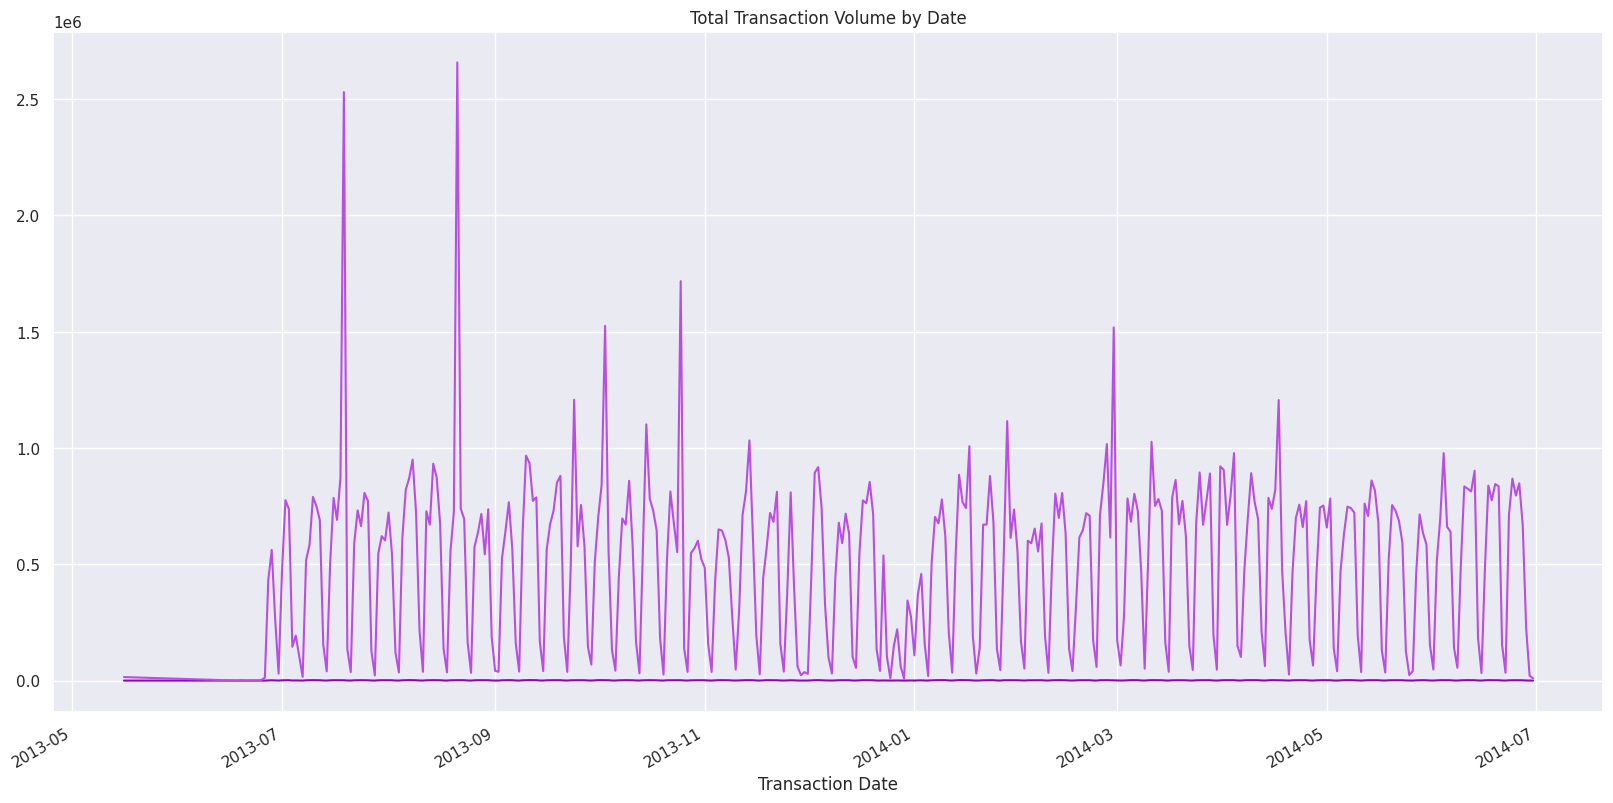

In [9]:
df.sort_values(by="Transaction Date", ascending=True).groupby("Transaction Date").size().plot(kind='line', figsize=(20, 10))
df.sort_values(by="Transaction Date", ascending=True).groupby("Transaction Date").sum("Amount")["Amount"].plot(kind='line', figsize=(20, 10), title="Total Transaction Volume by Date")

## 3. Amount

We've seen from the last notebook that the amount feature is pretty bottom heavy, with some very discrepant values in the millions that make the distribution pretty weird. Most of the values are in the hundreds and thousands, but a few samples contain values in the hundreds of thousands to millions.

To fix this issue when training the model, we'll apply a logarithmic scale to the amount values and then quantize them for a classification task downstream.

Since we've removed the negative values (refunds) from the dataset, applying a logarithmic scale won't cause any troubles. However, if we ever consider using the refund values downstream for any models, we should keep this in mind.


Text(0.5, 1.0, 'Histogram of original Amount values')

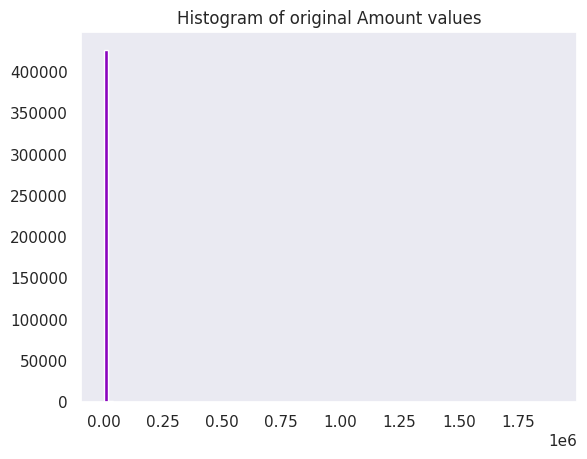

In [10]:
plt.figure()
plt.grid(False)
plt.hist(df['Amount'], bins=100)
plt.title('Histogram of original Amount values')

As we can see, even with 100 bins we still get some pretty weird distribution due to magnitude of difference in the amount samples.

In [11]:
import numpy as np
import math

def quantize(data: np.ndarray, num_bins: int, min_value: float = 0.01, max_value: float = 1e7):
    log_min = math.log1p(min_value)
    log_max = math.log1p(max_value)
    bin_edges = np.logspace(log_min, log_max, num=num_bins+1, base=math.e) - 1
    bin_edges = np.concatenate([[-np.inf], [0], bin_edges, [np.inf]])

    def _quantize(x):
        if x < 0:
            return 0  # bin for negative values (refunds)
        elif x == 0:
            return 1  # bin for zero values
        else:
            return np.digitize(x, bin_edges) - 1
    quant_inputs = np.array([_quantize(x) for x in data])
    return quant_inputs, bin_edges
    
quant_inputs, bin_edges = quantize(df['Amount'], num_bins=20)

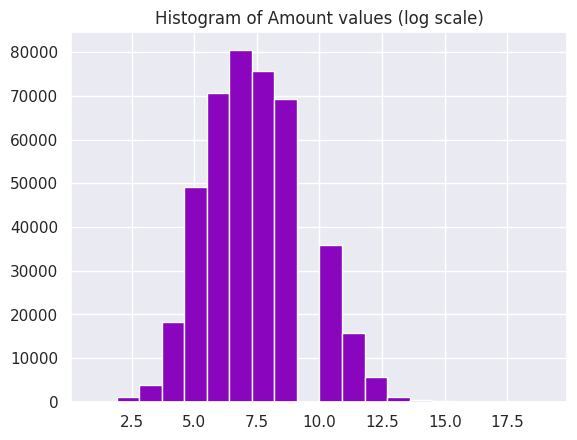

In [12]:
df['Original Amount'] = df['Amount']
df['Amount'] = quant_inputs

plt.figure()
plt.hist(df['Amount'], bins=20)
plt.title('Histogram of Amount values (log scale)')
plt.savefig('histogram_amount_values_log.png')

With this scaling, we can get a much nicer distribution. However, it's still somewhat of a normal distribution. This may be a problem for our training since we have much more data points in the ~4 to ~ 12 range of the distrbution

We should consider upsampling these points.

## Transaction Date

It seems that we have very few data points on the lower portion of our transaction dates.

Text(0.5, 1.0, 'Histogram of original Transaction Date values on Dataset 2012-2013')

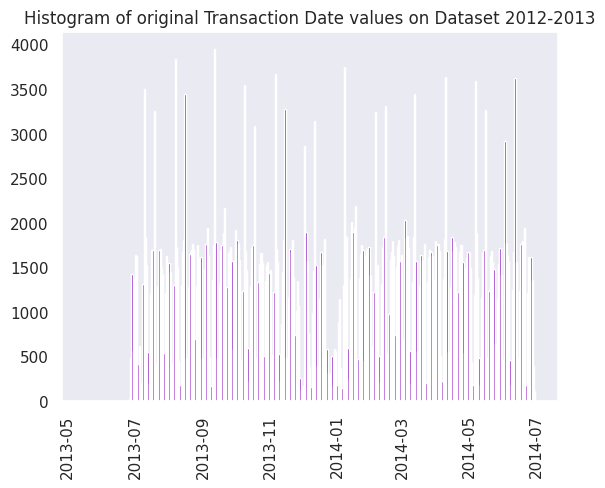

In [13]:
plt.figure()
plt.grid(False)
plt.hist(df['Transaction Date'], bins=365)
plt.xticks(rotation='vertical')
plt.title('Histogram of original Transaction Date values on Dataset 2012-2013')

Let's count the number and percentage of samples in the lower portion of our data points to see if they are either outliers or if we should keep them either way.

In [14]:
lower_portion_df = df[df['Transaction Date'] < pd.to_datetime('2013-03')]
print(f'len lower portion: {len(lower_portion_df)}')
print(f'percentage lower portion: {len(lower_portion_df)/len(df)}')
lower_portion_df.head()

len lower portion: 0
percentage lower portion: 0.0


,Year-Month,Agency Number,Agency Name,Cardholder Last Name,Cardholder First Initial,Amount,Vendor,Transaction Date,Posted Date,Merchant Category Code (MCC),Original Amount


In [15]:
mean_lower_portion_amount = lower_portion_df['Amount'].abs().mean()
mean_upper_portion_amount = df[df['Transaction Date'] >= pd.to_datetime('2013-03')]['Amount'].abs().mean()
print(f'Mean amount transacted on the lower portion: {mean_lower_portion_amount}')
print(f'Mean amount transacted on the upper portion: {mean_upper_portion_amount}')
                                                                                   
                                                                       

Mean amount transacted on the lower portion: nan
Mean amount transacted on the upper portion: 7.42378346778908


The lower portion of our transactions account for only 1.6% of the data points, and the mean amount transacted in these portions is more or less equal to the one in the upper portions.

It seems that these values are of transactions that were made in the first part of the year but were only delivered/posted a few months later, so they fell into the category of the latter half of the dataset.
Let's explore just a little bit more to see if there's any important data points in there. 

In [16]:
upper_portion_df = df[df['Transaction Date'] >= pd.to_datetime('2013-03')]


In [17]:
set(lower_portion_df['Agency Name'].unique()) - set(upper_portion_df['Agency Name'].unique())

set()

There's no Agency represented in the lower portion that is not represented in the latter portions. Let's count how many data points of each one of the agencies that we lose if we just don't use the lower portion.

In [18]:
datapoint_losses = pd.DataFrame(lower_portion_df.groupby('Agency Name').size()).rename(columns={0:'count_lower'})

In [19]:
upper_portion_counts_per_agency = pd.DataFrame(upper_portion_df.groupby('Agency Name').size()).rename(columns={0:'count_upper'})
datapoint_losses = datapoint_losses.join(other=upper_portion_counts_per_agency, on='Agency Name', how='left')

In [20]:
datapoint_losses['loss_percentage'] = (datapoint_losses['count_lower'] / (datapoint_losses['count_upper'] + datapoint_losses['count_lower']))

<AxesSubplot: >

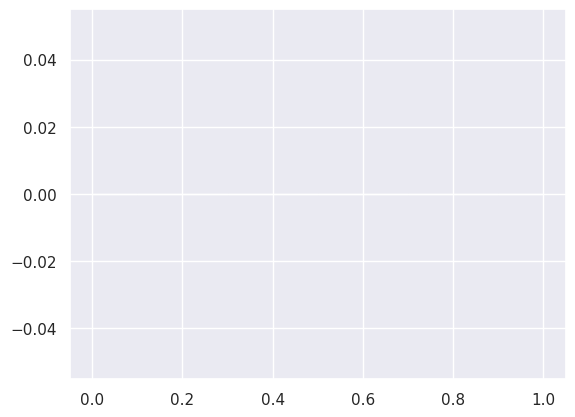

In [21]:
datapoint_losses['loss_percentage'].hist()

In [22]:
datapoint_losses.sort_values('loss_percentage', ascending=False).head(10)

,count_lower,count_upper,loss_percentage
Agency Name,,,


It looks like we only lose a significant amount of data points (18%) for one agency, which already has very low representation in the dataset. From this, we can conclude that we can ignore the values before 2013-03 and only use the upper half of the dataset.

In [23]:
df['Transaction Date'].iloc[0]

Timestamp('2013-07-30 00:00:00')

In [24]:
from pandas import Timestamp

def filter_after_date(df: pd.DataFrame, date: Timestamp):
    return df[df['Transaction Date'] > date]

df = filter_after_date(df, date=pd.to_datetime('2013-03'))

Text(0.5, 1.0, 'Histogram of Transaction Dates (filtered after 2013-03) values on Dataset 2012-2013')

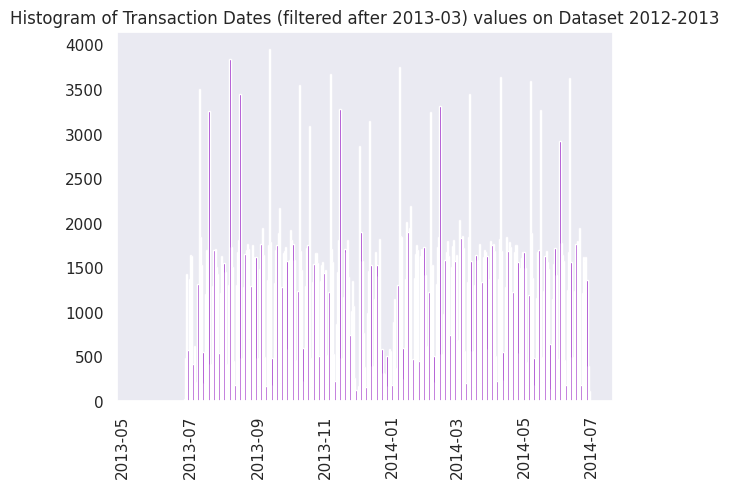

In [25]:
plt.figure()
plt.grid(False)
plt.hist(df['Transaction Date'], bins=365)
plt.xticks(rotation='vertical')
plt.title('Histogram of Transaction Dates (filtered after 2013-03) values on Dataset 2012-2013')

Our new transaction dates also have a little bit of seasonality to them, which is expected. We can try upsampling these dates as well, but I think this intrisic seasonal nature of the data is also interesting for our model to learn.